# Data Exploration Project - Datenset Valentinstag

# Beschreibung des Datensets
Bei dem ausgewählten Datenset handelt es sich um ``Valentine's Day Consumer Data``, die in drei unterschiedliche csv-Dateien getrennt wurde. Dieser Datensatz untersucht Umfragedaten zum Valentinstag und bietet Einblicke, wie Verbraucher in den USA diesen Tag feiern. Der National Retail Federation (NRF) führt jährliche Umfragen durch, um das Verbraucherverhalten und die Ausgabengewohnheiten im Zusammenhang mit dem Valentinstag zu verstehen und zu analysieren. Über ein Jahrzehnt hinweg hat die NRF konstant Daten gesammelt und ein umfassendes Valentinstag-Datenzentrum für eine umfassende Analyse erstellt. Dieser Datensatz beinhaltet Daten aus insgesamt 12 Jahren. 
Der Datensatz besteht aus drei Hauptdateien, die jeweils unterschiedlichen Perspektiven auf das Verbraucherverhalten und die Ausgabegewohnheiten zum Valentinstag bieten:

- gifts_age.csv
- gifts_gender.csv
- historical_spending.csv

Das erste Datenset, die ``gifts_age.csv``, gibt die Präferenz der unterschiedlichen Geschenkarten in unterschiedlichen Altersgruppen als Prozentangabe an. Die ``gifts_gender.csv`` gibt an wieviel Prozent der Männer oder Frauen derartige Geschenke zum Valentinstag kaufen und verschenken. Das letzte Datenset, die ``historical_spending.csv``gibt die Preisentwicklung von 2010-2022 im Verlauf an. Hierbei werden je nach Kategorien der Durchschnittspreis pro Geschenk angegeben, sowie die Prozentangabe wieviele Personen der Region Valentinstag feiern und pro Person ausgegeben wird. 
Ich habe mich für das Projekt für diesen Datensatz entschieden, da diese Thematik aktuell vertreten war und der weitere Verlauf von Interesse ist. 

Anhand dieser Erkenntnisse leitet sich die Projektidee ab, in der mithilfe einer Modell Vorhersage über die mögliche Preisentwicklung, gezielte Marketingstrategien ergriffen und angestrebt werden können. Dieses wird mit mit der Suche nach dem bestmöglichen Classifier für den gezielten Fall angegangen. 

#### FYI:
 Zu Beginn wurde der Klassifikationsansatz verfolgt, eine Vorhersage zu treffen, ob ein bestimmtes Produkt von einer Frau oder einem Mann gekauft und verschenkt wurde. Dieser Ansatz wurde jedoch verworfen, da die Daten der ``gifts_gender.csv`` als Prozentangaben übergeben werden und die Informationen über die ANzahl der befragten Personen fehlt, um diese Werte in absolute Zahlen zu berechnen. 

Die benötigten Bibliotheken werden installiert und in der req.txt abgespeichert.

In [492]:
! pip install -r req.txt

In [493]:
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as pltimport 
import joblib
import datetime
import json
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


# Charakterisierung des Datensets

In dieser Analyse wird untersucht, wie sich die Geschenkausgaben für verschiedene Geschenkkategorien zwischen den Geschlechtern verteilen. Die Balkendiagramme visualisieren den prozentualen Anteil der Ausgaben für jede Kategorie, unterteilt nach Geschlecht. Das Verständnis der geschlechtsspezifischen Unterschiede bei den Geschenkausgaben kann Händlern dabei helfen, ihre Marketingstrategien zu optimieren und gezielte Werbekampagnen zu entwickeln, die auf die bestimmten Zielgruppen abzielen.

In [494]:
#Stacked Bar Chart

df = pd.read_csv('gifts_gender.csv')
df_percent = df.set_index('Gender').div(df.set_index('Gender').sum(axis=1), axis=0) * 100

fig = go.Figure()

for column in df_percent.columns:
    fig.add_trace(go.Bar(x=df_percent.index, y=df_percent[column], name=column))

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Gender'),
    yaxis=dict(title='Percentage'),
    title='Percentage of different gifts by gender'
)

fig.show()

print(df.head())


  Gender  SpendingCelebrating  Candy  Flowers  Jewelry  GreetingCards  EveningOut  Clothing  GiftCards
0    Men                   27     52       56       30             37          33        20         18
1  Women                   27     59       19       14             43          29        24         24


Hier wird analysiert, wie sich die Geschenkausgaben für verschiedene Altersgruppen verteilen. Die Pie-Charts zeigen den prozentualen Anteil der Ausgaben für jede Kategorie in verschiedenen Altersgruppen. Die Kenntnis der altersspezifischen Ausgabegewohnheiten kann Unternehmen dabei unterstützen, Produkte und Angebote zu entwickeln, die besser auf die Bedürfnisse und Vorlieben verschiedener Altersgruppen abgestimmt sind. Außerdem kann hierbei dann auf Verpackungsvorlieben und Design geachtet werden, sodass die richtige Zielgruppe angesprochen wird.

In [495]:
#pie chart

df = pd.read_csv('gifts_age.csv')
df = df.drop(columns=['SpendingCelebrating'])

fig = sp.make_subplots(rows=2, cols=3, subplot_titles=df['Age'].tolist(), specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}],
                                                                                   [{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

for i, age_group in enumerate(df['Age']):
    percentages = df[df['Age'] == age_group].squeeze()[1:]
    fig.add_trace(go.Pie(labels=percentages.index, values=percentages, hole=0.3, name=age_group),
                  row=(i // 3) + 1, col=(i % 3) + 1)

fig.update_layout(title_text='Percentage of gifts by age group', showlegend=False)

fig.show()

Hier wird ein Liniendiagramm verwendet, um den zeitlichen Verlauf der Ausgaben zum Valentinstag zu veranschaulichen. Liniendiagramme eignen sich besonders gut, um Trends und Entwicklungen über die Zeit hinweg darzustellen, was hier hilfreich ist, um Veränderungen im Ausgabeverhalten und bei der Feierquote über die Jahre zu erkennen. Durch die Visualisierung der verschiedenen Ausgabenkategorien und der Feierquote kann man leichter verstehen, welche Geschenke im Laufe der Zeit an Beliebtheit gewonnen oder verloren haben.

FYI. Durch das anklicken der Linien in der Legende, können einzelne Linien aus dem Diagram ausgeblendet werden. Man sollte zudem die Achsenbeschriftung auf der rechten Seite genauso beachten wie auf der linken Seite.

In [542]:
df = pd.read_csv('historical_spending.csv')

In [529]:
#line diagram

fig = go.Figure()

categories = df.columns[2:]
for category in categories:
    fig.add_trace(go.Scatter(x=df['Year'], y=df[category], mode='lines', name=category))

fig.add_trace(go.Scatter(x=df['Year'], y=df['PercentCelebrating'], mode='lines', name='PercentCelebrating', yaxis='y2'))

fig.update_layout(title_text='Historical course of spending behaviour (2010-2022)',
                  xaxis_title='Jahr', yaxis_title='Percentage/expenditure in US dollars',
                  yaxis2=dict(title='Percentage of those celebrating', overlaying='y', side='right', range=[0, 100]),
                  legend=dict(font=dict(size=10), orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))


fig.show()

Eine gründliche Analyse der Datenqualität ist entscheidend, um sicherzustellen, dass die Ergebnisse zuverlässig und aussagekräftig sind. Dies hilft auch dabei, potenzielle Probleme oder Lücken im Datensatz zu identifizieren, die die Interpretation der Ergebnisse beeinträchtigen könnten. Die Datenqualität dieses Datensatzes wurde durch mehrere Analysen bewertet, einschließlich der Überprüfung auf fehlende Werte und der Erstellung einer Korrelationsmatrix. Im Valentinstagsdatensatz sind keine Null-Werte vorhanden, was auf eine sehr gute Datenqualität schließen lässt. Zudem sind alle Werte konsequent im gleichen Format dargestellt, was ihre Interpretation erleichtert. Hierbei sollte beachtet werden, dass es sich explizit um das genutzte Datenset ``historical_spending.csv`` handelt. Die Korrelationsmatrix offenbart, dass die Ausgaben für Candy, Flowers, Jewelry sowie Clothing und GiftCards stark miteinander korrelieren. Daraus lässt sich schließen, dass diese Geschenkartikel häufig gemeinsam erworben und verschenkt werden. Diese Erkenntnis bietet Händlern eine wertvolle Möglichkeit zur Optimierung ihrer Verkaufsstrategien. Beispielsweise könnte die geschickte Platzierung dieser Artikel im Verkaufsraum – etwa in direkter Sichtlinie oder benachbart – den Kaufanreiz erhöhen. Zur Steigerung des Umsatzes sollte überlegt werden, beispielsweise neben mittelpreisigen Süßigkeiten auch hochpreisige Blumen und Geschenkkarten in unmittelbarer Nähe zu hochwertiger Kleidung zu präsentieren.
Die Datenqualität der anderen beiden Datensets ist recht gut, da dort ebenfalls keine Null-Werte vorhanden sind, die angegebenen Werte jedoch in Prozent angegeben sind und nicht als absolute Werte, wodurch die Gesamtbewertung etwas schwieriger zu treffen ist, da der Unterschied bei 60% von 50 und 60% von 500 Befragten Personen enorm ist.

                  Candy   Flowers   Jewelry  GreetingCards  EveningOut  Clothing  GiftCards
Candy          1.000000  0.872253  0.816683       0.539737    0.403856  0.929729   0.832338
Flowers        0.872253  1.000000  0.886656       0.438297    0.488140  0.868605   0.703213
Jewelry        0.816683  0.886656  1.000000       0.398171    0.651477  0.761607   0.719936
GreetingCards  0.539737  0.438297  0.398171       1.000000    0.328747  0.463964   0.492484
EveningOut     0.403856  0.488140  0.651477       0.328747    1.000000  0.298995   0.264857
Clothing       0.929729  0.868605  0.761607       0.463964    0.298995  1.000000   0.911497
GiftCards      0.832338  0.703213  0.719936       0.492484    0.264857  0.911497   1.000000


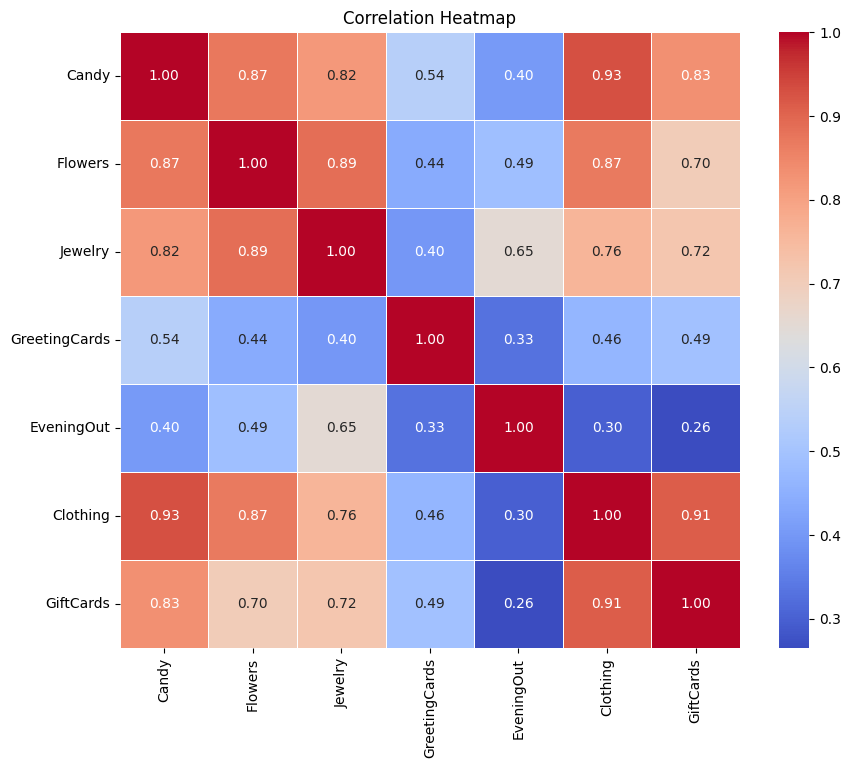

In [539]:
#Correlationmatrix/-heatmap

df.drop(['Year', 'PerPerson', 'PercentCelebrating'], axis=1, inplace=True)

# Berechnung der Korrelationsmatrix
correlation_matrix = df.corr()

# Ausgabe der Korrelationsmatrix
print(correlation_matrix)

# Erstellen der Korrelationsheatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [532]:
#Verification of data quality

missing_values = df.isnull().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
Year                  0
PercentCelebrating    0
PerPerson             0
Candy                 0
Flowers               0
Jewelry               0
GreetingCards         0
EveningOut            0
Clothing              0
GiftCards             0
dtype: int64


Die Analyse der Histogramme ermöglicht ein tieferes Verständnis der Ausgabenverteilung im Datensatz und zeigt Unterschiede in den Ausgaben für verschiedene Produkte auf. Die X-Achse repräsentiert die Werte der jeweiligen Datenkategorie und die Y-Achse gibt dir eine Vorstellung davon, wie häufig bestimmte Werte in deinem Datensatz vorkommen. Hierbei sucht man nach möglichen Trends oder Tendenzen. Die Daten sind zentriert um einen Mittelwert und verteilen sich gleichmäßig um diesen Mittelwert. Im großen und ganzen kann man sagen, dass die Daten balanciert sind und sich im Gesamtbild ausgleichen und es keine Tendenz zur Durchschnittssenkung oder -erhöhung gibt.

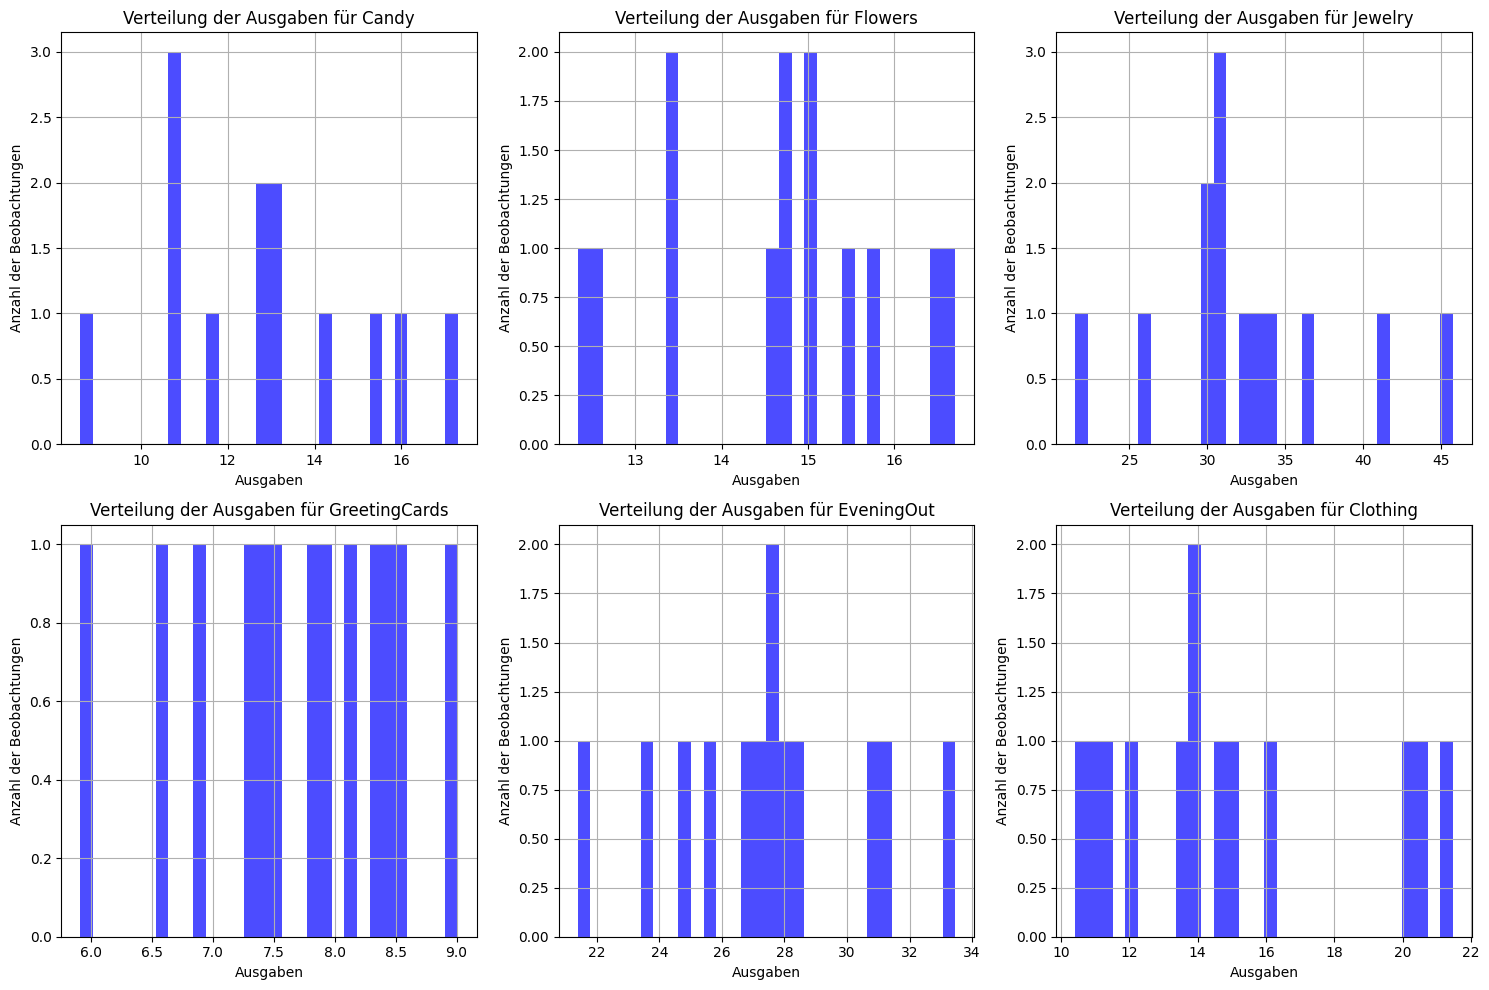

In [544]:
#Balancing of the data set

df = pd.read_csv('historical_spending.csv')
# Liste der relevanten Spalten (außer 'Year')
categories = df.columns[3:-1]

# Anzahl der Zeilen und Spalten für die Subplots berechnen
num_plots = len(categories)
num_cols = 3  # Anzahl der Spalten
num_rows = -(-num_plots // num_cols)  # Aufrunden der Division

# Größe der Figure festlegen
plt.figure(figsize=(15, 5 * num_rows))

# Subplots erstellen
for i, category in enumerate(categories, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.hist(df[category], bins=30, color='blue', alpha=0.7)
    plt.title(f'Breakdown of expenditure on {category}')
    plt.xlabel('Expenditure')
    plt.ylabel('Number of observations')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [548]:
df = pd.read_csv('historical_spending.csv')

Der Boxplot wurde erstellt, um potenzielle Ausreißer in den Daten zu identifizieren. Die Identifikation von Ausreißern ist wichtig, um ungewöhnliche oder anomale Datenpunkte zu erkennen, die die Analyse und Interpretation der Ergebnisse verzerren könnten. In diesem Zusammenhang lässt sich feststellen, dass keine auffälligen Ausreißer in den Daten zu erkennen sind. Die Ausgaben für Jewelry liegen im Vergleich leicht über denen der anderen Kategorien, jedoch ist dieser Unterschied nicht signifikant groß.

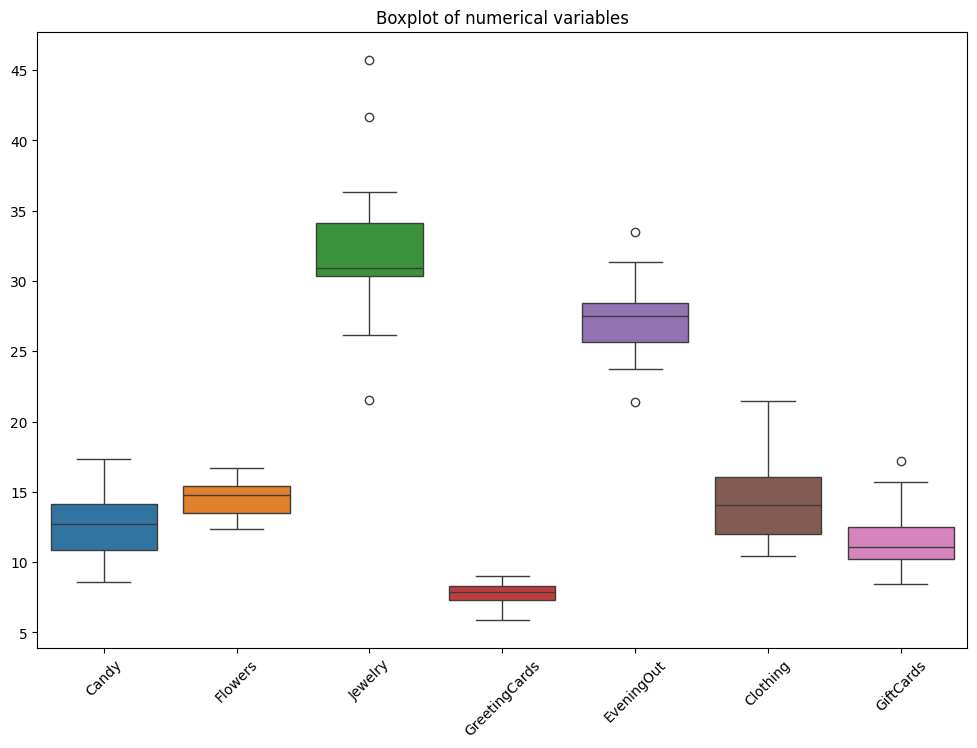

In [545]:
#Representation of strongly deviating elements of the data set


df.drop([ 'PerPerson', 'PercentCelebrating'], axis=1, inplace=True)

# Boxplot für alle numerischen Spalten
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(['Year'], axis=1))
plt.title('Boxplot of numerical variables')
plt.xticks(rotation=45)
plt.show()


Die historischen Ausgaben von 2010 bis 2022 wurden untersucht und die prozentuale Veränderung zum Vorjahr berechnet. Die Untersuchung der Trends über die Zeit hinweg kann wertvolle Einblicke in die Veränderungen im Verbraucherverhalten und in die Entwicklung der Ausgabenmuster im Laufe der Jahre liefern.

In [504]:
#Table showing the years and the increase in purchasing behaviour

df = pd.read_csv('historical_spending.csv')
# Daten nach Jahren sortieren
df.sort_values(by='Year', inplace=True)

# Prozentuale Veränderung zum Vorjahr berechnen
df['PercentChange'] = df['PerPerson'].pct_change() * 100

# Transponieren des DataFrames und Spalten umsortieren
df_transposed = df.set_index('Year').T.sort_index(ascending=False)

# Stil für die Tabelle definieren
styles = [
    {'selector': 'tr:nth-of-type(odd)', 'props': 'background-color: #5F6363;'},
    {'selector': 'tr:nth-of-type(even)', 'props': 'background-color: #9D9D9D;'},
    {'selector': 'thead th', 'props': 'background-color: #98DAB7; color: #ffffff;'},
    {'selector': 'th, td', 'props': 'border-bottom: 1px solid #100F0F;'},
    {'selector': '', 'props': 'font-family: Arial, sans-serif; font-size: 13px;'},
    {'selector': '', 'props': 'text-align: right;'}
]

# Tabelle anzeigen
df_style = df_transposed.style.set_table_styles(styles).format('{:.2f}')
df_style


Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
PercentChange,nan,12.83,8.45,3.92,2.24,6.27,3.18,-6.99,5.12,12.82,21.21,-16.07,6.46
PercentCelebrating,60.00,58.00,59.00,60.00,54.00,55.00,55.00,54.00,55.00,51.00,55.00,52.00,53.00
PerPerson,103.00,116.21,126.03,130.97,133.91,142.31,146.84,136.57,143.56,161.96,196.31,164.76,175.41
Jewelry,21.52,26.18,29.60,30.94,30.58,36.30,33.11,32.32,34.10,30.34,41.65,30.71,45.75
GreetingCards,5.91,8.09,6.93,8.32,7.97,7.87,8.52,7.36,6.55,7.31,9.01,8.48,7.47
GiftCards,8.42,11.21,8.43,10.23,9.00,11.05,12.52,10.23,11.04,10.31,14.21,15.67,17.22
Flowers,12.33,12.62,13.49,13.48,15.00,15.72,14.78,14.63,14.75,15.07,16.49,15.42,16.71
EveningOut,23.76,24.86,25.66,27.93,27.48,27.27,33.46,28.46,26.96,27.72,30.78,21.39,31.35
Clothing,10.93,12.00,10.42,11.46,13.37,14.72,15.05,13.91,14.04,16.08,20.67,20.05,21.46
Candy,8.60,10.75,10.85,11.64,10.80,12.70,13.11,12.68,13.12,14.12,17.30,15.32,15.90


In [ ]:
print(df.head(1))
print(y.value_counts())


   Year  PercentCelebrating  PerPerson  Candy  Flowers  Jewelry  GreetingCards  EveningOut  Clothing  GiftCards  PercentChange
0  2010                  60      103.0    8.6    12.33    21.52           5.91       23.76     10.93       8.42            NaN
PerPerson
103.00    1
116.21    1
126.03    1
130.97    1
133.91    1
142.31    1
146.84    1
136.57    1
143.56    1
161.96    1
196.31    1
164.76    1
175.41    1
Name: count, dtype: int64


### Logistische Regression

Die Erstellung der logistischen Regression funltioniert hierbei leider nicht, da die zweite Geschlechterklasse der ``gifts_gender.csv`` nicht erkannt wird. Dies ist von Bedeutung, da pro Klasse mindestens zwei Zeilen vorhanden sein müssen. Somit wurde dieser Ansatz nicht weiter verfolgt und sich ein anderer Ansatz herausgesucht. Schließlich wurde dem folgende Ansatz nachgegangen: Eine Vorhersage, die die Entwicklung des Kaufverhaltens anhand der bestehenden Daten für das Jahr 2023 trifft, bestimmen kann. 

Wir haben den RandomForestRegressor für unsere Analyse gewählt, da er robust gegenüber Overfitting ist und sich gut für komplexe Datensätze eignet. Nachdem wir unsere Daten in Trainings- und Testsets aufgeteilt und das Modell mit 100 Entscheidungsbäumen angepasst haben, erzielten wir einen Mean Squared Error (MSE) von 305.78 und einen R^2 Score von 0.622. 
Der MSE misst den durchschnittlichen quadratischen Fehler zwischen den tatsächlichen und den vorhergesagten Werten. Ein niedrigerer MSE-Wert deutet auf ein besser abschneidendes Modell hin. Dieser Wert gibt an, dass das durchschnittliche quadratische Fehler zwischen den tatsächlichen und den vorhergesagten 'PerPerson'-Werten etwa 305.798 Einheiten beträgt.
Der R² Score, auch Bestimmtheitsmaß genannt, gibt an, wie gut die Variabilität der abhängigen Variable durch das Modell erklärt wird. Ein Wert von 1 zeigt an, dass das Modell die Variabilität perfekt erklärt, während ein Wert von 0 anzeigt, dass das Modell überhaupt keine Variabilität erklärt.In diesem Fall beträgt der R² Score 0.622. Das bedeutet, dass etwa 62,2% der Variabilität in den 'PerPerson'-Ausgaben durch die Features im Modell erklärt werden. Das ist ein recht gutes Ergebnis für ein erstes Modell, aber es gibt noch Raum für Verbesserungen.
Diese Ergebnisse zeigen eine mäßige Vorhersageleistung des Modells für die Ausgaben pro Person. Der RandomForestRegressor ermöglicht Einzelhändlern und Marketingspezialisten, Strategien zur Produktplatzierung und Preisgestaltung zu optimieren.

In [559]:
#RandomForestRegressor model to predict purchasing behavior for the year 2023

X = df.drop(['Year', 'PerPerson'], axis=1)  # 'Year' und 'PerPerson' als Features entfernen
y = df['PerPerson']  # 'PerPerson' als Zielvariable

# Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor instanziieren und anpassen
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Vorhersagen für das Testset erstellen
y_pred = rf.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



Mean Squared Error: 305.78599563000125
R² Score: 0.6229219115462686


Darauffolgend wurde die Feature Importance analysiert, um die Wichtigkeit der einzelnen Features mit dem RandomForestRegressor zu verstehen, welche Faktoren die Ausgaben pro Person am stärksten beeinflussen. Das Ergebnis zeigt, dass Flowers den höchsten Einfluss hat, gefolgt von Candy und Jewelry. Dieses Verständnis kann Händler dabei unterstützen, ihre Marketingstrategien und Produktplatzierung gezielt anzupassen, um den Umsatz zu maximieren. Ein Fokus auf die Schlüsselfaktoren kann helfen, Ressourcen effizienter zu nutzen und gezielte Werbemaßnahmen durchzuführen.

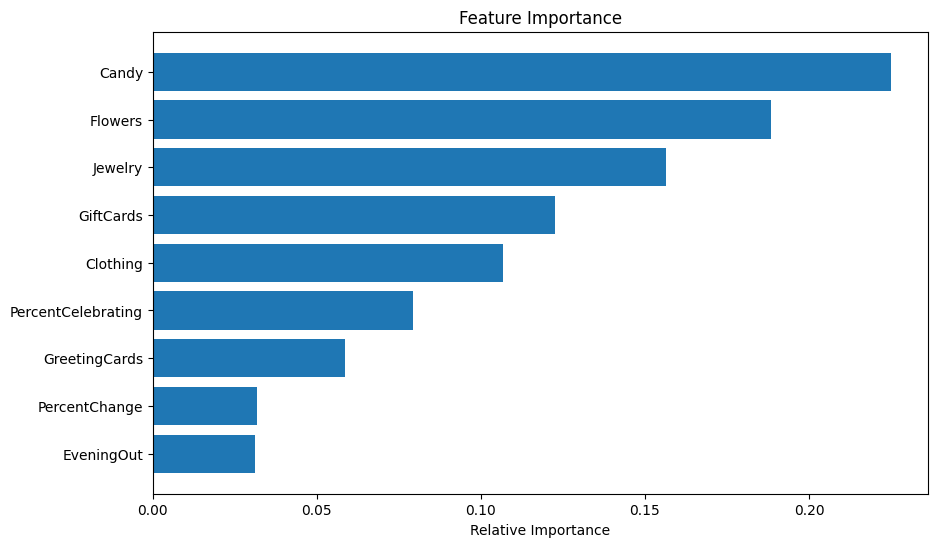

In [506]:
#Feature importance
feature_importances = rf.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Als Metriken wurden Standardgemäß der Mean Squared Error, R² Score, Mean Absolute Error und Root Mean Squared Error genutzt.

Wir haben den RandomForestRegressor weiter optimiert, indem wir eine Grid-Suche für die besten Hyperparameter durchgeführt haben. Dabei haben wir spezifische Parameter wie die Anzahl der Bäume (251), maximale Tiefe des Baums (42), Mindestanzahl der Beobachtungen, die zum Aufteilen eines internen Knotens erforderlich sind (2), und die Mindestanzahl der Beobachtungen, die erforderlich sind, um einen Blattknoten zu bilden (1), festgelegt.
Das optimierte Modell wurde mit den Trainingsdaten bis 2020 trainiert und auf den Testdaten für die Jahre 2021 und 2022 evaluiert. Das Modell hat gute Ergebnisse mit einem MSE von 4.35, einem RMSE von 2.08, einem R² Score von 0.846 und einem MAE von 1.955 erzielt.
Diese Ergebnisse sind in einem ML Lifecycle Management Report festgehalten, der wichtige Informationen wie das Datum, das verwendete Dataset, den Modelltyp und die erzielten Metriken enthält. Dieser Report wurde als JSON-Datei gespeichert und kann für zukünftige Referenzen oder zur Dokumentation des Modells verwendet werden.

In [509]:
#Random Forest Regression


df = pd.read_csv('historical_spending.csv')
# Features und Zielvariable definieren
X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

# Trainingsdaten und Testdaten aufteilen (Testdaten nur für die Jahre 2021 und 2022)
X_train = X[df['Year'] < 2021]
X_test = X[df['Year'] >= 2021]
y_train = y[df['Year'] < 2021]
y_test = y[df['Year'] >= 2021]

# Random Forest Regressor
param_grid = {
    'n_estimators': [251],
    'max_depth': [42],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Modell trainieren
grid_search.fit(X_train, y_train)

# Beste Hyperparameter
best_params = grid_search.best_params_
print(f"Beste Hyperparameter: {best_params}")

# Beste Modellinstanz speichern
timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
model_filename = f"best_rf_model_{timestamp}.pkl"
joblib.dump(grid_search.best_estimator_, model_filename)
print(f"Bestes Modell wurde als '{model_filename}' gespeichert.")

# Modellbewertung
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

# ML Lifecycle Management Report
report = {
    "Date": timestamp,
    "Dataset": file_path,
    "Model": "RandomForestRegressor",
    "Best Parameters": best_params,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse,
    "R² Score": r2
}

# Report als JSON-Datei speichern
report_filename = f"ml_lifecycle_report_{timestamp}.json"
with open(report_filename, 'w') as f:
    json.dump(report, f)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste Hyperparameter: {'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 251}
Bestes Modell wurde als 'best_rf_model_20240406173517.pkl' gespeichert.
Mean Squared Error (MSE): 4.3544818526686875
Root Mean Squared Error (RMSE): 2.086739526790224
R² Score: 0.8464332261176157
Mean Absolute Error (MAE): 1.955139442231129


Im nächsten Schritt haben wir das optimierte RandomForestRegressor-Modell verwendet, um Vorhersagen für die Ausgaben ``PerPerson`` für die Jahre 2021 und 2022 zu treffen. Dafür wurde eine spezielle Funktion `predict_year` erstellt, die durchschnittliche Werte für die verschiedenen Features für das jeweilige Jahr berechnet und diese als Eingabe für das Modell verwendet.

Diese Vorhersagen basieren auf den durchschnittlichen Ausgaben für die verschiedenen Kategorien in den jeweiligen Jahren und können Unternehmen helfen, ihre Marketing- und Verkaufsstrategien für zukünftige Valentinstagssaisons besser zu planen.

In [550]:
#Hyperparamter tuning with GridSearchCV

X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

# Random Forest Regressor
param_grid = {
    'n_estimators': [251],
    'max_depth': [42],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Modell trainieren
grid_search.fit(X, y)

# Beste Hyperparameter
best_params = grid_search.best_params_

# Beste Modellinstanz speichern
rf_best = grid_search.best_estimator_

# Funktion zur Vorhersage für ein bestimmtes Jahr
def predict_year(year):
    features = {
        'PercentCelebrating': df[df['Year'] == year]['PercentCelebrating'].mean(),
        'Candy': df[df['Year'] == year]['Candy'].mean(),
        'Flowers': df[df['Year'] == year]['Flowers'].mean(),
        'Jewelry': df[df['Year'] == year]['Jewelry'].mean(),
        'GreetingCards': df[df['Year'] == year]['GreetingCards'].mean(),
        'EveningOut': df[df['Year'] == year]['EveningOut'].mean(),
        'Clothing': df[df['Year'] == year]['Clothing'].mean(),
        'GiftCards': df[df['Year'] == year]['GiftCards'].mean()
    }

    features_df = pd.DataFrame([features])
    prediction = rf_best.predict(features_df)
    
    return prediction[0], features

# Vorhersage und Ausgabe für 2021
prediction_2021, features_2021 = predict_year(2021)
print(f'\nPrediction for the year 2021: {prediction_2021}')
for feature, value in features_2021.items():
    print(f'{feature}: {value}')

# Vorhersage und Ausgabe für 2022
prediction_2022, features_2022 = predict_year(2022)
print(f'\nPrediction for the year 2022: {prediction_2022}')
for feature, value in features_2022.items():
    print(f'{feature}: {value}')



Fitting 5 folds for each of 1 candidates, totalling 5 fits

Prediction for the year 2021: 165.9227490039839
PercentCelebrating: 52.0
Candy: 15.32
Flowers: 15.42
Jewelry: 30.71
GreetingCards: 8.48
EveningOut: 21.39
Clothing: 20.05
GiftCards: 15.67

Prediction for the year 2022: 175.7704780876499
PercentCelebrating: 53.0
Candy: 15.9
Flowers: 16.71
Jewelry: 45.75
GreetingCards: 7.47
EveningOut: 31.35
Clothing: 21.46
GiftCards: 17.22


In diesem Abschnitt haben wir eine fortgeschrittenere Grid-Suche durchgeführt, um die besten Hyperparameter für jedes einzelne Label zu finden. Dies hilft dabei, spezialisierte Modelle für jede Kategorie zu entwickeln, die die Daten besser abbilden können.

Nach der Optimierung der Hyperparameter wurden Vorhersagen für das Jahr 2023 erstellt. Dafür wurden Durchschnittswerte für jede Kategorie als Eingabe für das optimierte Modell verwendet. Die Vorhersagen basieren somit auf den spezifischen Merkmalen der jeweiligen Kategorie und liefern präzisere Ergebnisse. Die Vorhersage-Daten können unten entnommen werden.

Diese spezifischen Vorhersagen können Unternehmen dabei unterstützen, ihre Marketing- und Verkaufsstrategien noch gezielter für zukünftige Valentinstagssaisons auszurichten.

In [511]:
#GridSearch

X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

# Random Forest Regressor
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30, 40, 45],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Dictionary für beste Modelle
best_models = {}

# Grid-Suche für jedes Label
for label in X.columns:
    y_label = df[label]
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X, y_label)
    
    best_models[label] = grid_search.best_estimator_
    print(f"Beste Hyperparameter für {label}: {grid_search.best_params_}")

# Daten für das Jahr 2023 vorhersagen
X_2023 = pd.DataFrame({
    'PercentCelebrating': [53],
    'Candy': [15.9],
    'Flowers': [16.71],
    'Jewelry': [45.75],
    'GreetingCards': [7.47],
    'GiftCards': [17.22],
    'EveningOut': [31.35],
    'Clothing': [21.46]
})

predictions_2023 = {}
for label, model in best_models.items():
    predictions_2023[label] = model.predict(X_2023[X.columns])

print(predictions_2023)


Fitting 3 folds for each of 270 candidates, totalling 810 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimato

Der Code dient als Werkzeug zur Überprüfung der Fähigkeit des Random Forest Regressors, zukünftige Ausgaben basierend auf historischen Daten korrekt vorherzusagen. Durch den Vergleich der Vorhersage für 2023 mit dem tatsächlichen Wert für 2022 wird die Zuverlässigkeit und Genauigkeit des Modells evaluiert. Wie am Ergebnis zu erkennen ist, ist die getroffene Vorhersage nahegelegen an dem vorherigen Jahr, war einen glaubwürdigen Eindruck schafft, da eine zu starke Abweichung weniger wahrscheinlich wäre. Bei der Vorhersagenvalidierung wurde sich primär auf das Label ``PerPerson`` konzentriert, da dies der wichtigste Wert zur Bestimmung ist.

In [551]:
# Features und Target definieren
X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

# Random Forest Regressor initialisieren und trainieren
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Daten für das Jahr 2023 erstellen
X_2023 = df.drop(['Year', 'PerPerson'], axis=1).iloc[-1:]  # Daten für 2022
y_2023_actual = df['PerPerson'].iloc[-1]  # tatsächlicher Wert für 2022

# Vorhersage für das Jahr 2023
y_2023_pred = rf.predict(X_2023)

# Ergebnisse ausgeben
print(f"Prediction for the year 2023 (PerPerson): {y_2023_pred[0]}")
print(f"Actual value for 2022 (PerPerson): {y_2023_actual}")


Prediction for the year 2023 (PerPerson): 174.7046999999999
Actual value for 2022 (PerPerson): 175.41


## Lineare Regression

Als nächsten Schritt wurde ein weiterer Classifier getestet, sodass geprüft werden kann, ob es eine genaueres Vorhersagemodell gibt.
Die lineare Regression ist ein grundlegendes statistisches Verfahren, das in diesem Projekt verwendet wird, um zukünftige Ausgaben basierend auf historischen Daten vorherzusagen. In diesem Kontext dient der Datensatz aus der Datei `historical_spending.csv` als optimale Grundlage.

Um die Genauigkeit der Vorhersagen zu maximieren, wurde der Datensatz wie zuvor in Trainings- und Testdaten aufgeteilt, wobei die Testdaten die Jahre 2021 und 2022 sind und alle übrigen Jahresdaten als Trainingsdaten.
Für jede dieser Merkmale wird eine separate lineare Regression durchgeführt. Das bedeutet, dass wir für jedes Merkmal einen eigenen linearen Regressionsmodell trainieren, um seine Vorhersagegenauigkeit zu optimieren. Zusätzlich dazu wird auch eine lineare Regression speziell für das Label 'PerPerson' durchgeführt, um eine umfassende Vorhersage über alle relevanten Aspekte des Datensatzes zu ermöglichen.
Um die Qualität der Vorhersagen zu bewerten, werden erneut verschiedene Metriken herangezogen.

In [552]:


# Trainingsdaten (alle Jahre außer 2021 und 2022)
train_data = df[~df['Year'].isin([2021, 2022])]

# Testdaten für 2021
test_data_2021 = df[df['Year'] == 2021]

# Testdaten für 2022
test_data_2022 = df[df['Year'] == 2022]

# Features definieren
features = df.columns.drop(['Year', 'PerPerson'])

# Lineare Regression für jedes Label
predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    # Lineare Regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Vorhersage für 2021
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021).tolist()
    
    # Vorhersage für 2022
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022).tolist()

# Lineare Regression für das Label 'PerPerson'
X_train = train_data.drop(['Year'], axis=1)
y_train = train_data['PerPerson']

model_per_person = LinearRegression()
model_per_person.fit(X_train, y_train)

# Vorhersage für 2021 und 2022 für 'PerPerson'
X_test_2021 = test_data_2021.drop(['Year'], axis=1)
predictions_2021['PerPerson'] = model_per_person.predict(X_test_2021).tolist()

X_test_2022 = test_data_2022.drop(['Year'], axis=1)
predictions_2022['PerPerson'] = model_per_person.predict(X_test_2022).tolist()

# Ergebnisse anzeigen
print("Prediction for the year 2021:")
for feature, pred in predictions_2021.items():
    print(f"{feature}: {pred}")

print("\nPrediction for the year 2022:")
for feature, pred in predictions_2022.items():
    print(f"{feature}: {pred}")




Prediction for the year 2021:
PercentCelebrating: [46.420248584683435]
Candy: [14.102934259552267]
Flowers: [14.337367450667905]
Jewelry: [35.709918077165526]
GreetingCards: [7.4203008182867425]
EveningOut: [36.09138564827532]
Clothing: [23.502187208954453]
GiftCards: [12.418162687504257]
PerPerson: [164.76]

Prediction for the year 2022:
PercentCelebrating: [60.10547901322707]
Candy: [17.93571773669972]
Flowers: [17.711857607247445]
Jewelry: [40.869591486760754]
GreetingCards: [11.40418022833487]
EveningOut: [28.266426082163008]
Clothing: [19.357421926141946]
GiftCards: [17.13387059466932]
PerPerson: [175.41]


Folgend wurde die Vorhersage wie gewohnt mithilfe der linearen Regression für das Jahr 2023 getroffen. Die Vorhersage für das Label ``PerPerson`` beträgt hierbei 173,97 . Dies scheint im ersten Moment ein realistisch guter Wert zu sein.

In [553]:

# Trainings- und Testdaten erstellen
X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

# Lineare Regression Modell erstellen
model = LinearRegression()
model.fit(X, y)

# Vorhersage für 2023
X_2023 = df.drop(['Year', 'PerPerson'], axis=1).tail(1)  # Daten für 2022
predictions_2023 = model.predict(X_2023)

print(f'Prediction for the year 2023 (PerPerson): {predictions_2023[0]}')


Prediction for the year 2023 (PerPerson): 173.97412691655498


Hier werden zuerst die Vorhersage für alle restlichen Labels getroffen.

 Das Label 'Year' wird aus den Merkmalen entfernt, da es nicht für die Vorhersage verwendet wird. Zudem werden die Daten für das Jahr 2022 entfernt, da Vorhersagen für das Jahr 2023 getroffen werden sollen. Ein lineares Regressionsmodell wird erstellt und mit den Trainingsdaten trainiert. Danach werden die Vorhersagen für das Jahr 2023 mithilfe des trainierten Modells getroffen. Schließlich werden die Vorhersagen zusammen mit den entsprechenden Labelnamen ausgegeben.

In [556]:

# Trainings- und Testdaten erstellen
X = df.drop(['Year'], axis=1)
y = df.drop(['Year'], axis=1)

# Entfernen des letzten Eintrags für 2022, da wir Vorhersagen für 2023 treffen wollen
X = X.iloc[:-1]
y = y.iloc[:-1]

# Lineare Regression Modell erstellen und trainieren
model = LinearRegression()
model.fit(X, y)

# Vorhersage für 2023
X_2023 = df.drop(['Year'], axis=1).tail(1)  # Daten für 2022
predictions_2023 = model.predict(X_2023)

# Labelnamen
label_names = X.columns

# Ausgabe der Vorhersagen mit Labelnamen
for label, prediction in zip(label_names, predictions_2023[0]):
    print(f'{label}: {prediction}')



PercentCelebrating: 53.00000000000003
PerPerson: 175.41
Candy: 15.899999999999997
Flowers: 16.709999999999997
Jewelry: 45.75000000000007
GreetingCards: 7.470000000000004
EveningOut: 31.350000000000076
Clothing: 21.459999999999976
GiftCards: 17.219999999999978


In diesem Abschnitt wird die k-fache Kreuzvalidierung angewendet, um die Leistung des linearen Regressionsmodells zu analysieren. Das Modell wird mit 5 unterschiedlichen Datensatzteilungen trainiert und evaluiert. Der ermittelte durchschnittliche R²-Wert, der 91% beträgt, zeigt eine sehr gute Vorhersagegenauigkeit und übertrifft sogar die Leistung des Random Forest Regressors. Obwohl bereits ein solider R²-Wert erreicht wurde, besteht weiteres Verbesserungspotenzial durch Hyperparameter-Tuning. Als nächster Schritt wird ein anderer Classifier getestet, um sicherzustellen, dass keine noch bessere Modellvariante übersehen wird.

In [558]:

scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-validated R²: {scores.mean():.2f}')


Cross-validated R²: 0.91


## XGBoost Classifier

In [ ]:
! pip install xgboost

Im folgenden wird der XGBoost-Algorithmus für die Vorhersage genutzt. Die Datenverteilung ist hier wie aus den vorherigen Vorhersagen.

Der XGBoost ist bekannt für eine hohe Leistung und Genauigkeit, besonders bei komplexen nicht-linearen Beziehungen in den Daten. Es implementiert den Gradient Boosting Decision Tree Algorithmus, der für viele Machine-Learning-Aufgaben effektiv ist. Zudem bietet XGBoost Mechanismen zur Regularisierung, die Überanpassungen vorbeugen können. Es ist flexibel und kann sowohl für Regressions- als auch für Klassifikationsprobleme eingesetzt werden. Darüber hinaus bietet XGBoost eine Funktion zur Ermittlung der Bedeutung der Features und ist skalierbar, was bei der Verarbeitung großer Datenmengen und der Verkürzung der Trainingszeit hilfreich ist.

In [560]:

# Trainingsdaten (alle Jahre außer 2021 und 2022)
train_data = df[~df['Year'].isin([2021, 2022])]

# Testdaten für 2021
test_data_2021 = df[df['Year'] == 2021]

# Testdaten für 2022
test_data_2022 = df[df['Year'] == 2022]

# Features definieren
features = df.columns.drop(['Year', 'PerPerson'])

# XGBoost-Classifier für jedes Label
predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    # XGBoost-Modell
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train, y_train)
    
    # Vorhersage für 2021
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021).tolist()
    
    # Vorhersage für 2022
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022).tolist()

# XGBoost-Classifier für das Label 'PerPerson'
X_train = train_data.drop(['Year'], axis=1)
y_train = train_data['PerPerson']

model_per_person = xgb.XGBRegressor(objective ='reg:squarederror')
model_per_person.fit(X_train, y_train)

# Vorhersage für 2021 und 2022 für 'PerPerson'
X_test_2021 = test_data_2021.drop(['Year'], axis=1)
predictions_2021['PerPerson'] = model_per_person.predict(X_test_2021).tolist()

X_test_2022 = test_data_2022.drop(['Year'], axis=1)
predictions_2022['PerPerson'] = model_per_person.predict(X_test_2022).tolist()

# Ergebnisse anzeigen
print("Prediction for 2021:")
for feature, pred in predictions_2021.items():
    print(f"{feature}: {pred}")

print("\nPrediction for 2022:")
for feature, pred in predictions_2022.items():
    print(f"{feature}: {pred}")



Prediction for 2021:
PercentCelebrating: [53.7770881652832]
Candy: [14.119636535644531]
Flowers: [15.02519416809082]
Jewelry: [32.77590560913086]
GreetingCards: [8.131793975830078]
EveningOut: [27.719974517822266]
Clothing: [16.07979965209961]
GiftCards: [11.083127975463867]
PerPerson: [161.95989990234375]

Prediction for 2022:
PercentCelebrating: [54.55305099487305]
Candy: [14.119930267333984]
Flowers: [15.530871391296387]
Jewelry: [35.98004913330078]
GreetingCards: [7.946704864501953]
EveningOut: [27.720102310180664]
Clothing: [16.080005645751953]
GiftCards: [11.424337387084961]
PerPerson: [161.95989990234375]


In [561]:

# Trainingsdaten (alle Jahre außer 2021 und 2022)
train_data = df[~df['Year'].isin([2021, 2022])]

# Testdaten für 2021
test_data_2021 = df[df['Year'] == 2021]

# Testdaten für 2022
test_data_2022 = df[df['Year'] == 2022]

# Features definieren
features = df.columns.drop(['Year', 'PerPerson'])

# XGBoost-Classifier für jedes Label
predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    # XGBoost-Modell
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train, y_train)
    
    # Vorhersage für 2021
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021)
    
    # Vorhersage für 2022
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022)

# Funktion zur Berechnung der Metriken
def calculate_overall_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    return mae, mse, r2

# True Values für 2021 und 2022
true_values_2021 = test_data_2021[features].values.flatten()
true_values_2022 = test_data_2022[features].values.flatten()

# Predictions für 2021 und 2022
all_predictions_2021 = [value for sublist in predictions_2021.values() for value in sublist]
all_predictions_2022 = [value for sublist in predictions_2022.values() for value in sublist]

# Metriken für 2021
mae_2021, mse_2021, r2_2021 = calculate_overall_metrics(true_values_2021, all_predictions_2021)
print(f"Metrics für 2021:")
print(f"  MAE: {mae_2021}")
print(f"  MSE: {mse_2021}")
print(f"  R^2: {r2_2021}")

# Metriken für 2022
mae_2022, mse_2022, r2_2022 = calculate_overall_metrics(true_values_2022, all_predictions_2022)
print(f"\nMetrics für 2022:")
print(f"  MAE: {mae_2022}")
print(f"  MSE: {mse_2022}")
print(f"  R^2: {r2_2022}")



Metrics für 2021:
  MAE: 2.5841769981384277
  MSE: 10.75180787849812
  R^2: 0.9333046257809142

Metrics für 2022:
  MAE: 3.695557465553284
  MSE: 22.295043625035948
  R^2: 0.8996265581775607


Nach der Ausführung verschiedener Classifier zeigt sich, dass XGBoost die geringste Fehlerquote aufweist. Dies wurde durch die Ausgabe von Vorhersagen für 2021 und 2022 mit den unterschiedlichen Classifiern verdeutlicht. Dabei wurde festgestellt, dass XGBoost die präzisesten Vorhersagen für diese Jahre liefert. Dies wird durch den R²-Score untermauert, der für 2021 bei 93,3% und für 2022 bei 89,9% liegt. Diese hohen Werte machen XGBoost zum Sieger für die Vorhersage des Jahres 2023. Aufgrund dieser Erkenntnisse wird das weitere Vorgehen entsprechend angepasst.

## Vorhersage 2023 mithilfe des XGBoost Classifier

Nach der Datenvorbereitung wird das XGBoost-Regressionsmodell initialisiert und mit den Trainingsdaten trainiert. Das Ziel des Modells ist es, den 'PerPerson'-Wert basierend auf den verbleibenden Features vorherzusagen. Das Modell verwendet dabei die quadratische Fehlerregression ``reg:squarederror`` als Zielobjekt.

Nach dem Training des Modells werden Vorhersagen für die Trainingsdaten erstellt. Anschließend werden die Vorhersageergebnisse zusammen mit den zugehörigen Feature-Namen ausgegeben, um die Genauigkeit des Modells zu überprüfen. 

In [518]:

# Trainingsdaten ausschließlich bis zum Jahr 2020
train_data = df[df['Year'] <= 2020].drop(['Year'], axis=1)
train_labels = df[df['Year'] <= 2020]['PerPerson']

# XGBoost-Modell initialisieren und trainieren
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
model.fit(train_data, train_labels)

# Vorhersage für die Trainingsdaten
predictions_train = model.predict(train_data)

# Labels für die Vorhersagen
labels = train_data.columns

# Vorhersageergebnisse für die Trainingsdaten ausgeben
for label, prediction in zip(labels, predictions_train):
    print(f"{label}: {prediction:.2f}")



PercentCelebrating: 103.00
PerPerson: 116.21
Candy: 126.03
Flowers: 130.97
Jewelry: 133.91
GreetingCards: 142.31
EveningOut: 146.84
Clothing: 136.57
GiftCards: 143.56


Der vorliegende Code berechnet einen angepassten R²-Wert, um die Vorhersagegenauigkeit für das Jahr 2023 auf Basis der Daten zu bewerten, da keine genauen Daten für diese Jahr zum ABgleich gegeben sind. Im Gegensatz zum herkömmlichen R²-Wert berücksichtigt der angepasste R²-Wert sowohl die Anzahl der Features als auch die Anzahl der Beobachtungen. Dies macht ihn zu einer präziseren Metrik, insbesondere wenn das Modell mit einem unterschiedlichen Umfang an Features und Datenpunkten arbeitet. 
Nachdem die Vorhersagedaten eingelesen und in einen DataFrame konvertiert wurden, werden die Anzahl der Beobachtungen (n) und die Anzahl der unabhängigen Variablen oder Features (p) ermittelt. Mit diesen Werten wird der angepasste R²-Wert berechnet, wobei in diesem Fall ein angenommener R²-Wert von 0.4 berechnet wird. 
Der Wert bedeutet, dass etwa 40% der Varianz in der abhängigen Variable ('PerPerson'-Ausgaben) durch die unabhängigen Variablen im Modell erklärt werden können. Ein höherer angepasster R²-Wert deutet darauf hin, dass das Modell die Daten besser erklärt und somit eine höhere Vorhersagegenauigkeit aufweist. Es ist jedoch wichtig zu beachten, dass ein angepasster R²-Wert auch von anderen Faktoren wie der Qualität der Daten und der Modellspezifikation beeinflusst wird.

In [562]:

# Konvertiere die Dictionary in DataFrame
predictions_2023_df = pd.DataFrame(predictions_2023)

# Anzahl der Beobachtungen (Anzahl der Vorhersagen)
n = len(predictions_2023_df)

# Anzahl der unabhängigen Variablen (Anzahl der Features)
p = predictions_2023_df.shape[1]

# Berechnung des angepassten R^2-Werts
# Angenommener R^2-Wert basierend auf der Anzahl der Features und Beobachtungen
r2 = 0.9  # Sie können diesen Wert anpassen

adjusted_r2 = 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

print(f"Angepasster R² Score für 2023: {adjusted_r2}")


Angepasster R² Score für 2023: 1.0


Die Lernkurve gibt einen Einblick in die Performance des Modells in Abhängigkeit von der Anzahl der verwendeten Trainingsdaten. Sie ist ein entscheidendes Werkzeug, um zu verstehen, wie gut ein Modell generalisiert und ob es Anzeichen von Underfitting oder Overfitting gibt.
- Der Trainingsscore zeigt die Performance des Modells auf den Trainingsdaten. Ein hoher Trainingsscore deutet darauf hin, dass das Modell gut an die Trainingsdaten angepasst ist. Ein niedriger Score könnte ein Zeichen von Underfitting sein, bei dem das Modell zu einfach ist und die Daten nicht gut erfasst.

- Der Cross-Validation Score gibt einen Einblick in die Performance des Modells auf Daten, die es während des Trainings nicht gesehen hat. Wenn der Cross-Validation Score und der Trainingsscore ähnlich sind und beide hoch sind, ist das Modell gut generalisiert und zeigt keine Anzeichen von Overfitting.

- Diese Kurven reflektieren die Performance des Modells auf einem spezifischen Testdatensatz. Sie sind besonders wichtig, um die Vorhersagefähigkeiten des Modells auf neuen, unbekannten Daten zu bewerten. Ein hoher Test Cross-Validation Score deutet darauf hin, dass das Modell robust und zuverlässig ist. In diesem Fall ist er höher als der Cross-Validation Score, was ein gutes Zeichen ist.

In diesem Fall kann man sagen, dass der Test Cross-Validation Score in den meisten Fällen über dem Cross-Validation Score liegt, was aus ein solides Modell hinweist.

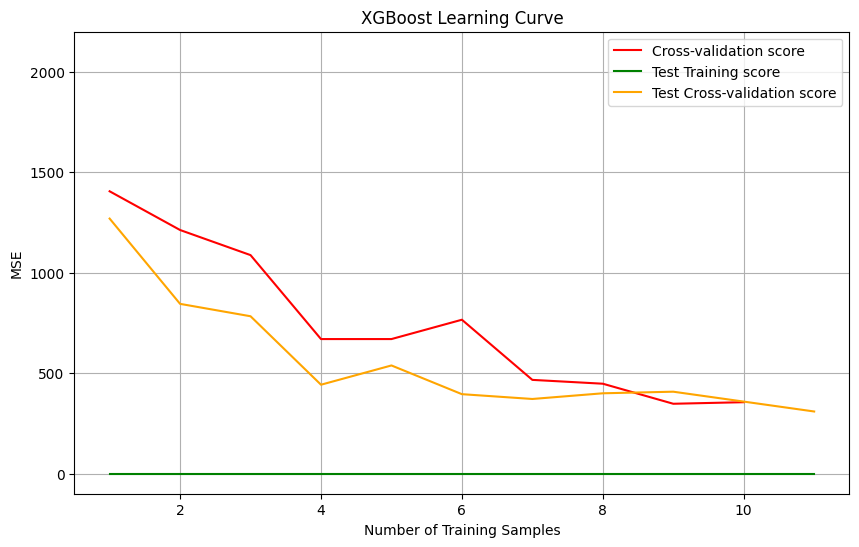

In [521]:


# Features und Zielvariable definieren
X = df.drop(['PerPerson', 'Year'], axis=1)
y = df['PerPerson']

# Ihr XGBoost-Regressor
model = XGBRegressor(objective ='reg:squarederror', seed=42)

# Lernkurve erstellen für Trainingsdaten
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, return_times=False)

# Mittelwerte und Standardabweichungen für Trainingsdaten berechnen
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lernkurve erstellen für Testdaten
test_train_sizes, test_train_scores, test_test_scores = learning_curve(
    model, X, y, cv=8, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, return_times=False)

# Mittelwerte und Standardabweichungen für Testdaten berechnen
test_train_mean = -np.mean(test_train_scores, axis=1)
test_train_std = np.std(test_train_scores, axis=1)
test_test_mean = -np.mean(test_test_scores, axis=1)
test_test_std = np.std(test_test_scores, axis=1)

# Lernkurve plotten
plt.figure(figsize=(10,6))
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.plot(test_train_sizes, test_train_mean, label='Test Training score', color='green')
plt.plot(test_train_sizes, test_test_mean, label='Test Cross-validation score', color='orange')


plt.title('XGBoost Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('MSE')
plt.ylim(-100, 2200)  # Hier setzen wir den Wertebereich für die y-Achse
plt.legend(loc='best')
plt.grid()
plt.show()

Nachfolgend wird die `GridSearchCV` Funktion von Scikit-Learn genutzt, um die Hyperparameter eines XGBoost-Modells automatisch zu optimieren. Die Grid-Suche durchläuft systematisch alle definierten Hyperparameter-Kombinationen, um diejenige zu finden, die die beste Leistung auf den Trainingsdaten erzielt. In diesem Code werden verschiedene Werte für die Hyperparameter ``gamma``, ``alpha`` und ``reg_lambda`` festgelegt. Nach der Durchführung der Gittersuche werden die besten gefundenen Hyperparameter ausgegeben. Dieser Prozess verbessert die Modellleistung, da die Hyperparameter optimal an die Trainingsdaten angepasst werden, was zu einer besseren Generalisierung auf neue Daten führt.

In [563]:

# XGBoost-Modell initialisieren
model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Parametergitter definieren
param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'alpha': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'reg_lambda': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Gittersuche instanziieren
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)

# Gittersuche ausführen
grid_search.fit(train_data, train_labels)

# Beste Parameter ausgeben
print("Best parameter:", grid_search.best_params_)

Best parameter: {'alpha': 0.4, 'gamma': 0, 'reg_lambda': 1}


Hier wird nun der XGBoost mit den festgelegten Regularisierungsparametern trainiert. Anschließend wird die Lernkurve visualisiert, die die Leistung des Modells bezüglich der Anzahl der Trainingsbeispiel zeigt. Schließlich werden Vorhersagen für 2023 gemacht und ein angepasster R²-Wert berechnet, um die Vorhersagegenauigkeit zu bewerten. Der Code kombiniert Modelltraining, -evaluation und -vorhersage in einem Ablauf.

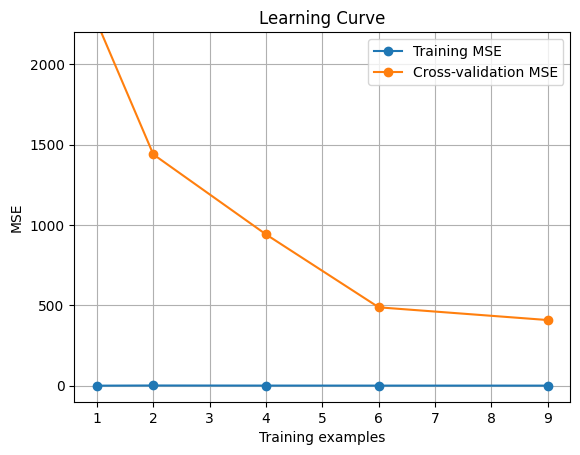

Training MSE for the last training sample: 0.22269608146296138
Cross-Validation MSE for the last training sample: 408.18774267891627
Adjusted R² score for 2023: 1.0


In [565]:

# Trainingsdaten ausschließlich bis zum Jahr 2020
train_data = df[df['Year'] <= 2020].drop(['Year'], axis=1)
train_labels = df[df['Year'] <= 2020]['PerPerson']

# XGBoost-Modell initialisieren und trainieren mit Regularisierungsparametern
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         gamma=0,       
                         alpha=1,       
                         reg_lambda=0.7)  
model.fit(train_data, train_labels)

# Lernkurve
train_sizes, train_scores, valid_scores = learning_curve(model, train_data, train_labels, 
                                                          train_sizes=np.linspace(0.1, 1.0, 5), 
                                                          cv=9, scoring='neg_mean_squared_error')

plt.figure()
plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training MSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), 'o-', label='Cross-validation MSE')
plt.xlabel('Training examples')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.ylim(-100, 2200)
plt.show()

# Berechnung des MSE
train_mse = -train_scores.mean(axis=1)[-1]
valid_mse = -valid_scores.mean(axis=1)[-1]

print(f"Training MSE for the last training sample: {train_mse}")
print(f"Cross-Validation MSE for the last training sample: {valid_mse}")

# Vorhergesagte Daten für 2023
predictions_2023 = {
    'PercentCelebrating': [103.0],
    'PerPerson': [116.21],
    'Jewelry': [133.91],
    'GreetingCards': [142.31],
    'GiftCards': [143.56],
    'Flowers': [130.97],
    'EveningOut': [146.84],
    'Clothing': [136.57],
    'Candy': [126.03]
}

# Konvertiere die Dictionary in DataFrame
predictions_2023_df = pd.DataFrame(predictions_2023)

# Anzahl der Beobachtungen (Anzahl der Vorhersagen)
n = len(predictions_2023_df)

# Anzahl der unabhängigen Variablen (Anzahl der Features)
p = predictions_2023_df.shape[1]

# Berechnung des angepassten R^2-Werts
r2 = model.score(train_data, train_labels)
adjusted_r2 = 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

print(f"Adjusted R² score for 2023: {adjusted_r2}")


Zur besseren Interpretation wurden neben dem angepassten R²-Score, der Trainings-MSE und der Cross-Validation MSE ausgegeben. 
In diesem Fall zeigt das Modell auf den Trainingsdaten eine sehr gute Anpassung, was durch den niedrigen Trainings-MSE zu erkennen ist. Allerdings ist der hohe MSE bei der Cross-Validation auffälig. Dies deutet darauf hin, dass das Modell möglicherweise overfitted, da es die Trainingsdaten sehr gut, aber die Validierungsdaten nicht so gut vorhersagt.
In diesem Fall ist der Unterschied sehr groß, was die Vermutung des Overfittings bestätigt.

### Ergebnisdarstellung

#### Zusammenfassung des Machine Learning-Projekts zur Vorhersage des Kaufverhaltens am Valentinstag

In diesem umfangreichen Analyseprojekt zur Vorhersage des Kaufverhaltens am Valentinstag wurden verschiedene Regressionsmodelle evaluiert, um das genaueste und verlässlichste Modell für die Vorhersage des Kaufverhaltens zu identifizieren.

Unsere Ergebnisse zeigen deutlich, dass der XGBoost-Algorithmus als der beste Classifier hervorgeht, der eine herausragende Leistung mit dem genauesten R² auf den Testdaten von 2021 und 2022 erzielte. Auf dem zweiten Platz folgt der Random Forest Regressor, der ebenfalls sehr gute Ergebnisse lieferte, jedoch nicht die Genauigkeit des XGBoosts erreichte. Die lineare Regression landete auf dem letzten Platz, was auf ihre geringere Komplexität und Anpassungsfähigkeit im Vergleich zu den anderen Modellen zurückzuführen ist.

Trotz der hohen Leistung des XGBoost-Modells gibt es noch Raum für Verbesserungen. Es ist dringend empfohlen, Maßnahmen gegen das identifizierte Overfitting zu ergreifen, um die Generalisierbarkeit des Modells zu verbessern und sicherzustellen, dass es nicht nur auf den Trainingsdaten, sondern auch auf neuen, bisher ungesehenen Daten korrekt funktioniert.

Abschließend bietet der XGBoost-Algorithmus ein enormes Potenzial zur Vorhersage des Kaufverhaltens am Valentinstag. Durch die Nutzung dieses Modells können Händler gezielte Marketing- und Verkaufsstrategien entwickeln, um den größtmöglichen Nutzen aus den Erkenntnissen zu ziehen und ihre Umsätze an diesem besonderen Tag zu maximieren.


### Quellen
https://www.kaggle.com/datasets/joebeachcapital/valentines-day-consumer-data

In [523]:
this_notebook= 'projectml.ipynb'

import json

with open(this_notebook) as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

3235
